In [171]:
from transformers import GPT2Tokenizer, AutoModelForCausalLM
from torch.nn.functional import log_softmax
import torch
import numpy as np
import json
from tqdm import tqdm
from nltk.tokenize import sent_tokenize
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler

In [172]:
def get_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
        return torch.device('mps')
    else:
        return torch.device('cpu')

device = get_device()
device

device(type='mps')

In [186]:
model = AutoModelForCausalLM.from_pretrained('gpt2')
model.to(device)
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
bos = tokenizer.bos_token_id
eos = tokenizer.eos_token_id

In [187]:
def encode(string):
    ids, words_ids, sentence_ids = [], [], []
    sentences = sent_tokenize(string, language='english')
    token_idx = 0
    for sent_id, sentence in enumerate(sentences):
        tokens = sentence.split(" ")
        for token in tokens:
            token_ids = tokenizer.encode(token, add_special_tokens=False)
            ids.extend(token_ids)
            words_ids.extend([token_idx] * len(token_ids))
            sentence_ids.extend([sent_id] * len(token_ids))
            token_idx += 1
    return ids, words_ids, sentence_ids

encode("Hello world! This is a test.")
            

([15496, 6894, 0, 1212, 271, 64, 9288, 13],
 [0, 1, 1, 2, 3, 4, 5, 5],
 [0, 0, 0, 1, 1, 1, 1, 1])

In [188]:
taskC_train = []
with open ("data/subtaskC_train.jsonl", "r", encoding="utf-8") as f:
    for line in f:
        if line:
            parsed = json.loads(line)
            taskC_train.append((parsed["text"], parsed["label"], parsed["id"]))

In [ ]:
taskC_dev = []
with open ("data/subtaskC_dev.jsonl", "r", encoding="utf-8") as f:
    for line in f:
        if line:
            parsed = json.loads(line)
            taskC_dev.append((parsed["text"], parsed["label"], parsed["id"]))

In [189]:
def perplexity(logits, labels):
    sm = log_softmax(logits, dim=-1)
    probs = []
    for i in range(labels.shape[1] - 1):
        next_idx = labels[0, i + 1].item()
        scores = sm[0, i, :]
        prob_next_idx = scores[next_idx].item()
        probs.append(prob_next_idx)

    probs = np.array(probs)
    probs = np.sum(probs)
    l = labels.shape[1] - 1
    ppl = - (1 / l) * np.sum(probs)
    return np.exp(ppl)

In [190]:
def last_index_of(item, arr):
    last = None
    for i, x in enumerate(arr):
        if x == item:
            last = i
    return last

def base0(arr):
    m = min(arr)
    return [i - m for i in arr]

In [191]:
def ppl_sentences(string):
    ids, words, sents = encode(string)
    result = []
    m = max(sents)
    for i in range(m+1):
        sent_start = sents.index(i)
        # make inclusive
        sent_end = last_index_of(i, sents) + 1
        input_ids = torch.tensor(
            [bos] + ids[sent_start:sent_end] + [eos],
            device=device
        ).unsqueeze(0)
        out = model(input_ids)
        ppl = perplexity(out.logits, input_ids)
        sent_length = len(set(words[sent_start:sent_end]))
        result.extend([ppl] * sent_length)
    return result
        
        
ppl_sentences("Hello world! My name is girlboss")

[1049.846958988214,
 1049.846958988214,
 1907.9163428919435,
 1907.9163428919435,
 1907.9163428919435,
 1907.9163428919435]

In [192]:
def ppl_sent_words(string):
    ids, words, sents = encode(string)
    result = []
    m = max(sents)
    for i in range(m+1):
        sent_start = sents.index(i)
        sent_end = last_index_of(i, sents) + 1
        input_ids = torch.tensor(
            [bos] + ids[sent_start:sent_end] + [eos],
            device=device
        ).unsqueeze(0)
        out = model(input_ids)
        sent_words = base0(words[sent_start:sent_end])
        mw = max(sent_words)
        for j in range(mw+1):
            # bos, inclusive -> +2
            li = last_index_of(j, sent_words)
            if (li is None):
                # somehow empty sentence?
                continue
            word_end = li + 2
            logits = out.logits[:, :word_end, :]
            labels = input_ids[:, :word_end]
            ppl = perplexity(logits, labels)
            result.append(ppl)
    return result
    
ppl_sent_words("Hello world! My name is girlboss")

[3999.6971419758097,
 1347.289351860791,
 468.2349159351564,
 2882.869780896676,
 485.7940347531757,
 2924.522525027994]

In [197]:
def ppl_words(string):
    ids, words, _ = encode(string)
    if len(ids) > 1022:
        window_size = 1024
        slide_amount = 256
        pos = 0
        input_ids = [bos] + ids + [eos]
        logits = []
        while True:
            end = pos+window_size
            window = input_ids[pos:end]
            partial_out = model(torch.tensor(window, device=device).unsqueeze(0))
            l = partial_out.logits
            take_from = 0 if pos == 0 else window_size - slide_amount
            window_out = l.cpu().detach().numpy()[0, take_from:]
            logits.extend(window_out)
            if end > len(ids):
                break
            pos += slide_amount
        logits = torch.tensor(logits).unsqueeze(0)
    else:
        out = model(
            torch.tensor([bos] + ids + [eos], device=device).unsqueeze(0),
        )
        logits = out.logits
    
    result = []
    input_ids = torch.tensor([bos] + ids + [eos]).unsqueeze(0)
    m = max(words)
    for i in range(m+1):
        # bos, inclusive
        li = last_index_of(i, words)
        if li is None: 
            continue
        end = li + 2
        ref = logits[:, :end, :]
        lab = input_ids[:, :end]
        ppl = perplexity(ref, lab)
        result.append(ppl)
    return result
        

In [198]:
def rolling_avg(arr, window_size=10):
    if window_size == 0:
        return arr
    r = []
    i = 0
    while i < len(arr):
        mid = window_size // 2
        start = max(i - mid, 0)
        end = min(i + mid, len(arr) + 1)
        current = sum(arr[start:end]) / (end - start)
        r.append(current)
        i += 1
    return r  

def rolling_variance(arr, window_size=10):
    r = []
    i = 0
    while i < len(arr):
        mid = window_size // 2
        start = max(i - mid, 0)
        end = min(i + mid, len(arr) + 1)
        current = np.var(arr[start:end])
        r.append(current)
        i += 1
    return r

def flatten_outliers(arr, maximum=5000):
    return [i if i <= maximum else maximum for i in arr]
    

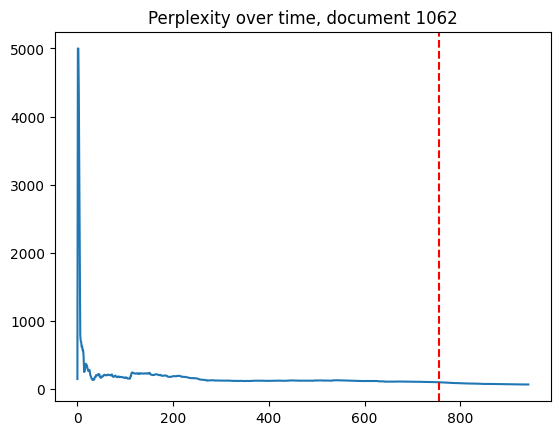

In [199]:
idx = 1062

_, words, _ = encode(taskC_train[idx][0])
p1 = ppl_words(taskC_train[idx][0])
p1 = flatten_outliers(p1, maximum=5000)
# p1 = flatten_outliers(p1)
# p2 = ppl_sent_words(taskC_train[idx][0])
# p2 = rolling_avg(p2, window_size=5)
# p3 = ppl_words(taskC_train[idx][0])


label = taskC_train[idx][1]

plt.plot(p1)
plt.axvline(label, color="red", linestyle="--")
plt.title(f"Perplexity over time, document {idx}")
plt.show()

In [156]:
processed_train = []

for i, (text, _ , _) in tqdm(enumerate(taskC_train), total=len(taskC_train)):
    p1 = ppl_words(text)
    p2 = ppl_sent_words(text)
    p3 = ppl_sentences(text)
    arr = np.array([p1, p2, p3])
    features = arr.T
    processed_train.append(features.tolist())

with open("data/ppl_train.json", "w", encoding="utf-8") as f:
    json.dump(processed_train, f, indent=4)


In [159]:
processed_dev = []

for i, (text, _ , _) in tqdm(enumerate(taskC_dev), total=len(taskC_dev)):
    p1 = ppl_words(text)
    p2 = ppl_sent_words(text)
    p3 = ppl_sentences(text)
    arr = np.array([p1, p2, p3])
    features = arr.T
    processed_dev.append(features.tolist())

with open("data/ppl_dev.json", "w", encoding="utf-8") as f:
    json.dump(processed_dev, f, indent=4)

(211, 3)